In [130]:
import numpy as np
import pandas as pd
import dfoote_struct_est_lib as dstruct
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Problem Set 3 - GMM

## 1. Matching the U.S. income distribution by GMM (5 points). In this problem set, you will use the comma-delimited data file hh inc synth.txt in the PS3/data folder, which contains the 121,085 observations (synthetic) on household U.S. income. Table 1 displays histogram counts and percentages moments listed in along with the midpoints of each bin. The first column in the data file gives the percent of the population in each income bin (the third column of Table 1). The second column in the data file has the midpoint of each income bin. So the midpoint of the first income bin of all household incomes less than 5,000 is 2,500.

(a) (0.5 point) Use the numpy.histogram() function to create the moments in Table 1 from the synthetic household income data in comma-delimited text file hh inc synth.txt by inputing the appropriate list of bin edges for the bins argument.

In [192]:
income = np.genfromtxt('data/hh_inc_synth.txt', delimiter=',')
income.shape

(121085,)

Notes

All but the last (righthand-most) bin is half-open. In other words, if bins is:

[1, 2, 3, 4]
then the first bin is [1, 2) (including 1, but excluding 2) and the second [2, 3). The last bin, however, is [3, 4], which includes 4.

In [132]:
#generate a list I can easily make into my bins list
l = [0,5000]
for x in range(0,39):
    l.append(l[-1] + 5000)

In [133]:
l = l + [250000, 351000]

In [152]:
counts, bins = np.histogram(income, bins=l)

(b)(1 points) Plot the histogram of the data hh inc synth.txt using the bins described in the first column of Table 1, which you used as an input to part (a), and the height being the percent of observations in that bin and not the count frequency (use the weights option rather than the density option in matplotlib.pyplot.hist). List the dollar amounts on the x- axis as thousands of dollars. That is, divide them by 1,000 to put them in units of thousands of dollars ($000s). Even though the top bin is listed as $250,000 and up in Table 1, the synthetic data are top-coded at $350,000, so set to last bin edge to $350,000. (It doesn’t look very good graphing it between 0 and ∞.) Because the 41st bar is 10 times bigger than the first 40 bars, divide it’s percentage by 10 just for plotting purposes. And because the 42nd bar is 20 times bigger than the first 40 bars, divide it’s percentage by 20 just for plotting purposes. You can do this by dividing the weights for observations in the last two bins by 10 and 20, respectively. In summary, your histogram should have 42 bars. The first 40 bars for the lowest income bins should be the same width. However, the last two bars should be different widths from each other and from the rest of the bars. It should look like Figure 1. [Hint: look at the matplotlib.pyplot.hist command option of bins and submit a list of bin edges for the bins option.]

Text(0.5, 0, 'Household income in thousands')

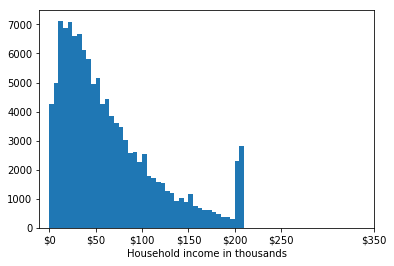

In [135]:
bins[-2] = bins[-3] + 5000
bins[-1] = bins[-2] + 5000
bs, bs1, bs2 = plt.hist(bins[:-1], bins, weights=counts)
plt.xticks(np.array([0, 50000, 100000, 150000, 200000, 250000, 350000]),
           ('$0', '$50', '$100', '$150', '$200', '$250', '$350'))
plt.xlabel(r'Household income in thousands')

(c) (1 points) Using GMM, fit the lognormal LN (x; μ, σ) distribution defined in the MLE notebook to the distribution of household income data using the moments from the data file. Make sure to try various initial guesses. (HINT: μ0 = ln(avg.inc.) might be good.) For your weighting matrix W , use a 42 × 42 diagonal matrix in which the diagonal elements are the moments from the data file. This will put the most weight on the moments with the largest percent of the population. Report your estimated values for μˆ and σˆ, as well as the value of the minimized criterion function e(x|θˆ)T W e(x|θˆ). Plot the histogram from part (a) overlayed with a line representing the implied histogram from your estimated lognormal (LN) distribution. Each point on the line is the midpoint of the bin and the implied height of the bin. Do not forget to divide the values for your last two moments by 10 and 20, respectively, so that they match up with the histogram.

In [183]:
def model_moments_1c(mu, sigma, bin_bound_list):
    bins = len(bin_bound_list) - 1
    model_moments = np.zeros(bins)
    for bin_ind in range(bins):
        if bin_ind == 0:
            model_moments[bin_ind] = \
                sts.lognorm.cdf(bin_bound_list[bin_ind], s=sigma,
                                scale=mu)
        elif bin_ind > 0 and bin_ind < bins - 1:
            model_moments[bin_ind] = \
                (sts.lognorm.cdf(bin_bound_list[bin_ind], s=sigma,
                                 scale=np.exp(mu)) -
                 sts.lognorm.cdf(bin_bound_list[bin_ind - 1], s=sigma,
                                 scale=np.exp(mu)))
        elif bin_ind == bins - 1:
            model_moments[bin_ind] = \
                (1 - sts.lognorm.cdf(bin_bound_list[bin_ind - 1],
                                     s=sigma, scale=np.exp(mu)))

    return model_moments


In [185]:
counts, bins = np.histogram(income, bins=l)
dmom = dstruct.data_moments(income)
bins = [x/1000 for x in bins]
model_mom = model_moments_1c(dmom[0], dmom[1], bins)

In [161]:
dmom[0]

67269.598228936

In [186]:
model_mom

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1.])

In [173]:
W = np.zeros((42,42),int)
np.fill_diagonal(W, model_mom)


In [179]:
W.sum()

0

2. Estimating the Brock and Mirman (1972) model by GMM (5 points). You can observe time series data in an economy for the following variables: (ct, kt, wt, rt). Data on (ct, kt, wt, rt) can be loaded from the file MacroSeries.txt in the PS3/data folder. This file is a comma separated text file with no labels. The variables are ordered as (ct, kt, wt, rt). These data have 100 periods, which are quarterly (25 years). Suppose you think that the data are generated by a process similar to the Brock and Mirman (1972). A simplified set of character- izing equations of the Brock and Mirman model are the following. (ct)−1 − βE 􏰀rt+1(ct+1)−1􏰁 = 0 (1) ct +kt+1 −wt −rtkt =0 (2) wt − (1 − α)ezt (kt)α = 0 (3)

(a) Estimate α, ρ, and μ by GMM using the unconditional moment conditions that E[εt] = 0 and E[βrt+1ct/ct+1 − 1] = 0. Assume β = 0.99. Use the identity matrix I(4) as your estimator of the optimal weighting matrix. Use the following four moment conditions to estimate the four parameters.
E􏰈zt+1−ρzt−(1−ρ)μ􏰉 =0 (6) 􏰆􏰂 􏰃􏰇
E zt+1 −ρzt −(1−ρ)μ zt =0 (7) 􏰆 zt+1 α−1 ct 􏰇
Eβαe kt+1c −1 =0 (8) t+1
 􏰆􏰄 zt+1 α−1 ct 􏰅 􏰇
E βαe kt+1c −1 wt =0 (9)

In [187]:
macro = pd.read_csv('data/MacroSeries.txt')

In [188]:
macro.columns

Index(['1.067109409061767906e+07', '8.040697000000000000e+06',
       '1.059437619404014759e+07', '9.541199796178368997e-01'],
      dtype='object')

In [193]:
macro = np.genfromtxt('data/MacroSeries.txt', delimiter=',')

In [205]:
c = macro[:,0]
k = macro[:,1]
w = macro[:,2]
r = macro[:,3]

In [206]:
df = pd.DataFrame({'c':c,'k':k,'w':w,'r':r})

In [207]:
df.head()

,c,k,w,r
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183
